<a href="https://colab.research.google.com/github/sylkip3/Applied-Machine-Learning/blob/main/CMP7239_Lab4_DecisionTree_UNSW_NB15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***CMP7239 Applied Machine Learning***

## Decision Tree — Applied to UNSW-NB15 Network Intrusion Detection Dataset

## Dr. Mohamed Ihmeida

> **Note:** This notebook replicates the exact steps from Lab 4 (Decision Tree on Iris dataset) applied to the UNSW-NB15 cybersecurity dataset for the CW1 assignment.

## Introduction to Decision Tree

**Decision trees** are a popular and powerful tool used in various fields such as `machine learning`, data mining, and statistics.

They provide a clear and intuitive way to make decisions based on data by modeling the relationships between different variables.

This notebook applies Decision Trees to the **UNSW-NB15** dataset — a real-world network intrusion detection benchmark containing normal and attack traffic across 9 attack categories.

**What is a Decision Tree?**

* A decision tree in machine learning is a versatile, interpretable algorithm used for predictive modelling.

* It structures decisions based on input data, making it suitable for both `classification` and `regression` tasks.

* A decision tree is a `flowchart-like structure` used to make decisions or predictions.

* It consists of nodes representing decisions or tests on attributes, branches representing the outcome of these decisions, and leaf nodes representing final outcomes or predictions.

* Each internal node corresponds to a test on an attribute, each branch corresponds to the result of the test, and each leaf node corresponds to a class label or a continuous value.

**Structure of a Decision Tree**

1. **Root Node**: Represents the entire dataset and the initial decision to be made.
2. **Internal Nodes**: Represent decisions or tests on attributes. Each internal node has one or more branches.
3. **Branches**: Represent the outcome of a decision or test, leading to another node.
4. **Leaf Nodes**: Represent the final decision or prediction. No further splits occur at these nodes.

# Advantages of Decision Trees

1. **Simplicity and Interpretability**: Decision trees are easy to understand and interpret. The visual representation closely mirrors human decision-making processes.
2. **Versatility**: Can be used for both classification and regression tasks.
3. **No Need for Feature Scaling**: Decision trees do not require normalization or scaling of the data.
4. **Handles Non-linear Relationships**: Capable of capturing non-linear relationships between features and target variables.

# Disadvantages of Decision Trees

1. **Overfitting**: Decision trees can easily overfit the training data, especially if they are deep with many nodes.
2. **Instability**: Small variations in the data can result in a completely different tree being generated.
3. **Bias towards Features with More Levels**: Features with more levels can dominate the tree structure.

**Applications of Decision Trees**

* *`Business Decision Making`*: Used in strategic planning and resource allocation.
* *`Healthcare`*: Assists in diagnosing diseases and suggesting treatment plans.
* *`Finance`*: Helps in credit scoring and risk assessment.
* *`Cybersecurity`*: Used to classify network traffic as normal or malicious — which is exactly what we do in this notebook.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the UNSW-NB15 dataset
# (Equivalent to: iris = load_iris() / X = iris.data / y = iris.target)

df = pd.read_csv(
    'UNSW_NB15.csv',
    dtype={
        'sport'      : str,
        'dsport'     : str,
        'ct_ftp_cmd' : str,
        'attack_cat' : str
    },
    low_memory=False
)

# ── Fix mixed-type columns ────────────────────────────────────────
df['sport']      = pd.to_numeric(df['sport'],      errors='coerce')
df['dsport']     = pd.to_numeric(df['dsport'],     errors='coerce')
df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').fillna(0)

# ── Clean attack_cat ──────────────────────────────────────────────
df['attack_cat'] = df['attack_cat'].str.strip().fillna('Normal').replace('', 'Normal')

# ── Drop identifier columns (no predictive value) ─────────────────
id_cols = ['srcip', 'dstip', 'Stime', 'Ltime']
df.drop(columns=[c for c in id_cols if c in df.columns], inplace=True)

# ── Encode categorical feature columns ───────────────────────────
le = LabelEncoder()
for col in ['proto', 'state', 'service']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# ── Impute missing values ─────────────────────────────────────────
feature_cols = [c for c in df.columns if c not in ['label', 'attack_cat']]
imputer = SimpleImputer(strategy='median')
df[feature_cols] = imputer.fit_transform(df[feature_cols])

# ── Drop rows where label is NaN ────────────────────────────────
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# ── Define X and y  (mirrors: X = iris.data / y = iris.target) ───
X = df[feature_cols].values
y = df['label'].values          # binary: 0 = Normal, 1 = Attack

feature_names = feature_cols
class_names   = ['Normal', 'Attack']

print(f'Dataset loaded successfully.')
print(f'X shape : {X.shape}  ({X.shape[1]} features)')
print(f'y shape : {y.shape}')
print(f'Classes : {class_names}')

Dataset loaded successfully.
X shape : (310399, 43)  (43 features)
y shape : (310399,)
Classes : ['Normal', 'Attack']


In [5]:
# Convert the dataset into a DataFrame for better EDA
# (Equivalent to: iris_df = pd.DataFrame(data=X, columns=iris.feature_names))

unsw_df = pd.DataFrame(data=X, columns=feature_names)
unsw_df['target'] = y

In [6]:
# Display basic information
print("Dataset Overview:")
print(unsw_df.head())
print("\nBasic Statistics:")
print(unsw_df.describe())
print("\nClass Distribution:")
print(unsw_df['target'].value_counts())
print("\nClass Distribution (labelled):")
print(unsw_df['target'].map({0: 'Normal', 1: 'Attack'}).value_counts())

Dataset Overview:
     sport  dsport  proto  state       dur  sbytes  dbytes  sttl  dttl  sloss  \
0   1390.0    53.0  120.0    2.0  0.001055   132.0   164.0  31.0  29.0    0.0   
1  33661.0  1024.0  120.0    2.0  0.036133   528.0   304.0  31.0  29.0    0.0   
2   1464.0    53.0  120.0    2.0  0.001119   146.0   178.0  31.0  29.0    0.0   
3   3593.0    53.0  120.0    2.0  0.001209   132.0   164.0  31.0  29.0    0.0   
4  49664.0    53.0  120.0    2.0  0.001169   146.0   178.0  31.0  29.0    0.0   

   ...  is_ftp_login  ct_ftp_cmd  ct_srv_src  ct_srv_dst  ct_dst_ltm  \
0  ...           0.0         0.0         3.0         7.0         1.0   
1  ...           0.0         0.0         2.0         4.0         2.0   
2  ...           0.0         0.0        12.0         8.0         1.0   
3  ...           0.0         0.0         6.0         9.0         1.0   
4  ...           0.0         0.0         7.0         9.0         1.0   

   ct_src_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_

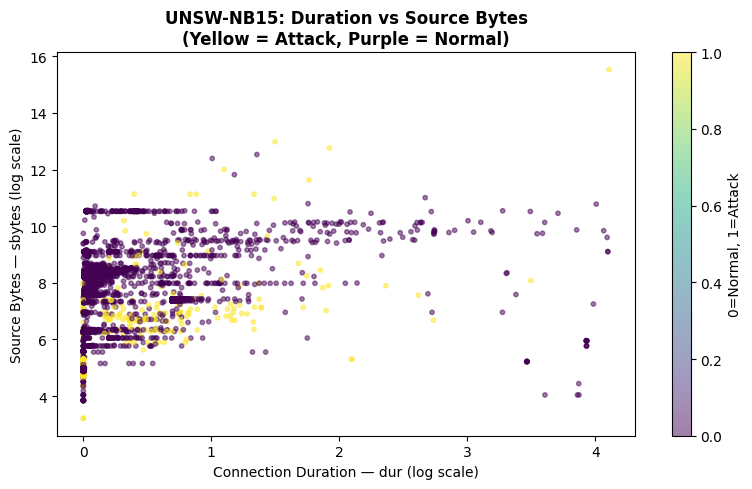

In [7]:
# Scatter plot of two key network features coloured by class
# (Equivalent to: plt.scatter sepal length vs sepal width coloured by target)

# Use a stratified sample for visibility (full dataset is 2.5M rows)
sample_idx = np.random.choice(len(unsw_df), size=5000, replace=False)
sample_df  = unsw_df.iloc[sample_idx]

dur_idx   = feature_names.index('dur')    if 'dur'    in feature_names else 0
sbyte_idx = feature_names.index('sbytes') if 'sbytes' in feature_names else 1

plt.figure(figsize=(8, 5))
plt.scatter(
    x = np.log1p(sample_df.iloc[:, dur_idx].clip(lower=0)),
    y = np.log1p(sample_df.iloc[:, sbyte_idx].clip(lower=0)),
    c = sample_df['target'],
    cmap = 'viridis',
    alpha = 0.5,
    s = 10
)
plt.xlabel('Connection Duration — dur (log scale)')
plt.ylabel('Source Bytes — sbytes (log scale)')
plt.title('UNSW-NB15: Duration vs Source Bytes\n(Yellow = Attack, Purple = Normal)', fontweight='bold')
plt.colorbar(label='0=Normal, 1=Attack')
plt.tight_layout()
plt.show()

In [8]:
# Splitting data for modeling
# (Exact replication: test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size    = 0.3,
    random_state = 42
)

print(f'Training set : {X_train.shape[0]:,} samples')
print(f'Test set     : {X_test.shape[0]:,} samples')

Training set : 217,279 samples
Test set     : 93,120 samples


In [9]:
# Initialize and train the Decision Tree Classifier
# (Exact replication: DecisionTreeClassifier(random_state=42))

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [10]:
# Predict on the test set
y_pred = clf.predict(X_test)

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision Tree model: {accuracy:.2f}")

Accuracy of the Decision Tree model: 0.99


In [12]:
# Print the Confusion Matrix and F1-Score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Confusion Matrix:
[[86071   324]
 [  289  6436]]
F1 Score: 0.9934249722607682


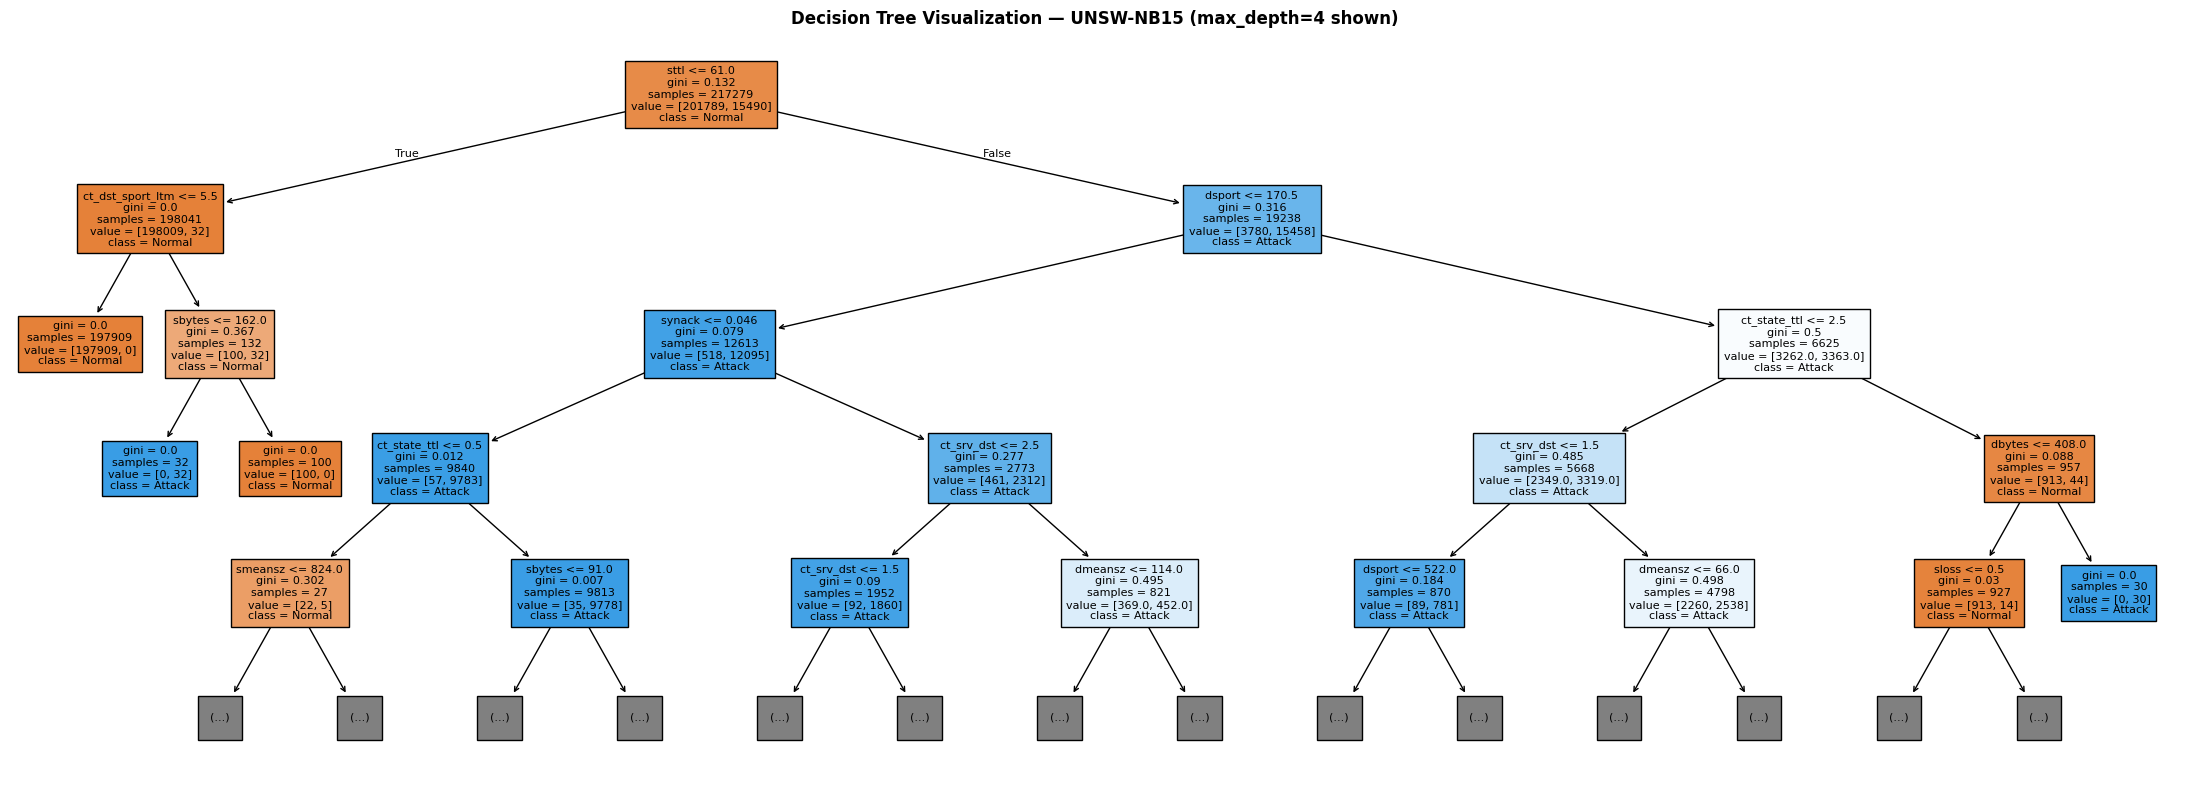

In [13]:
# Visualise the Decision Tree
# Note: max_depth=4 used for readability — full tree has many levels on UNSW-NB15
plt.figure(figsize=(22, 8))
plot_tree(
    clf,
    max_depth    = 4,
    feature_names = feature_names,
    class_names   = class_names,
    filled        = True,
    fontsize      = 8
)
plt.title("Decision Tree Visualization — UNSW-NB15 (max_depth=4 shown)",
          fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

In [14]:
# Display feature importance
# (Exact replication of lab step — adapted to UNSW-NB15 feature names)

feature_importances = pd.DataFrame(
    clf.feature_importances_,
    index   = feature_names,
    columns = ["Importance"]
)

print("Feature Importances:")
print(feature_importances.sort_values('Importance', ascending=False).head(15))

Feature Importances:
              Importance
sttl            0.786708
dsport          0.067920
ct_state_ttl    0.022139
ct_srv_dst      0.019745
dmeansz         0.010314
sbytes          0.008934
sport           0.008587
synack          0.008041
dbytes          0.006898
smeansz         0.006736
ct_srv_src      0.006515
Sload           0.004688
dur             0.004591
dtcpb           0.004179
Dload           0.004068


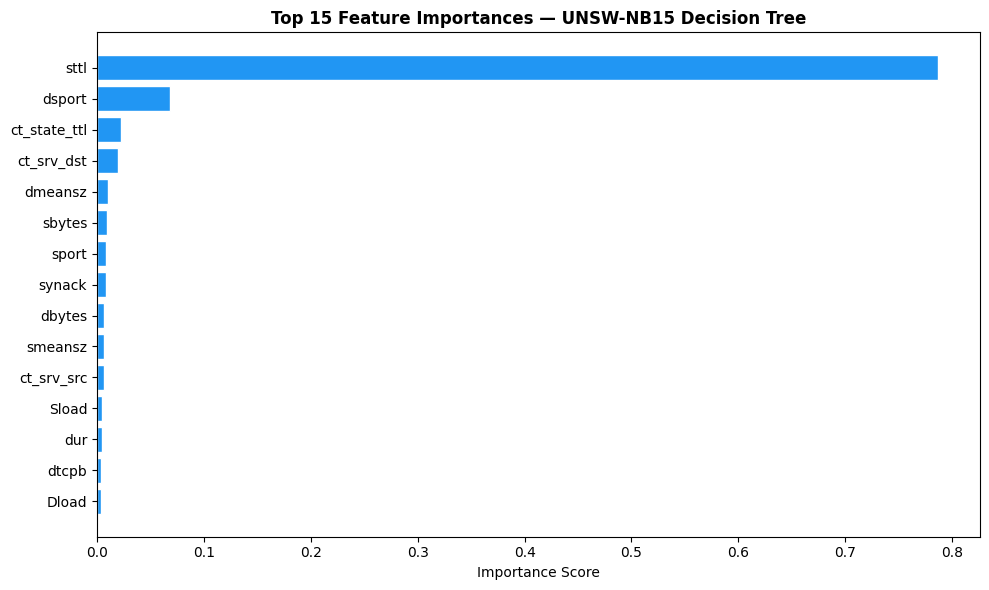

In [15]:
# Bar chart of top 15 most important features
top15 = feature_importances.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(top15.index[::-1], top15['Importance'][::-1], color='#2196F3', edgecolor='white')
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances — UNSW-NB15 Decision Tree', fontweight='bold')
plt.tight_layout()
plt.show()

***Task 2***

Save the decision tree model and upload to GitHub as well.

In [17]:
# Save the Decision Tree model
import joblib

joblib.dump(clf, 'decision_tree_unsw_nb15.pkl')
print('Model saved to decision_tree_unsw_nb15.pkl')

Model saved to decision_tree_unsw_nb15.pkl
